In [1]:
import sys
import getopt
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy import spatial
from copy import copy
import subprocess
from funcs import *
import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors as plt_colors

In [2]:
from IPython.display import display, Javascript
import time
import hashlib
import shelve
import subprocess
import os

def save_and_commit(notebook_path, branch_name, nc_file, commit_message):
    
    current_branch = subprocess.check_output(["git", "rev-parse", "--abbrev-ref", "HEAD"]).decode('ascii').strip()
    if current_branch != branch_name:
        raise ValueError('not on correct branch')
        
    if (os.path.exists(nc_file) or os.path.exists('./models/') or os.path.exists('./data/')) == False:
        raise ValueError('nc_file or target folder does not exist')
    
    start_md5 = hashlib.md5(open(notebook_path,'rb').read()).hexdigest()
    display(Javascript('IPython.notebook.save_checkpoint();'))
    current_md5 = start_md5
        
    while start_md5 == current_md5:
        time.sleep(1)
        current_md5 = hashlib.md5(open(notebook_path,'rb').read()).hexdigest()
                
    stage = ["git", "add", "{}".format(notebook_path)]
    commit = ["git", "commit", "-m", commit_message]
    try:
        proc = subprocess.check_output(stage, stderr=subprocess.STDOUT)
        proc = subprocess.check_output(commit, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError:
        raise ValueError('something went wrong')
        
    hashmark =  subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()
    save_model = ["cp", "{}".format(nc_file), "./models/{}_{}.nc".format(branch_name, hashmark)]
    proc = subprocess.check_output(save_model, stderr=subprocess.STDOUT)

    bk = shelve.open('./data/{}_{}.pkl'.format(branch_name, hashmark),'n')
    exceptions = ['NPI_50m_DEM', 'NPI_DEM', 'NPI_DEM_o', 'R2_50m_Vel', 'R2_50m_Vx', 'R2_50m_Vy', 'R2_Vel', 'R2_Vx', 'R2_Vy', 'Z_09', 'Z_14', 'Z_50m_09', 'Z_50m_14', 'Z_50m_20', 'Z_50m_90', 'bed', 'bed_mask', 'bed_mask_meta', 'bed_o', 'dhdt_0914', 'dhdt_50m_0914', 'mat_DEM_Vel', 'mat_RADAR', 'ocean_50m_mask', 'retreat_50m_mask','smb_50m_fit', 'smb_fit', 'smb_net_0914', 'smb_net_df', 'smb_x', 'smb_y', 'smb_z', 'smb_xyz_df', 'surf', 'surf_mask','surf_mask_meta', 'surf_o', 'thk', 'thk_mask', 'thk_mask_meta', 'thk_o', 'vel_0914', 'vel_50m_0914', 'vel_df', 'vel_x', 'vel_y', 'vel_z', 'vel_xyz_df', 'x_50m', 'y_50m']
    for k in sorted(globals()):
        if k in exceptions:
            continue
        if k.split('_')[0]=='':
            continue
        try:
            bk[k] = globals()[k]
        except Exception:
            print('{} was not saved'.format(k))
            pass
    bk.close()

In [3]:
filename = "icecap_conf.nc"
nc = NC(filename, 'w', format="NETCDF3_CLASSIC")
var = nc.createVariable("pism_overrides", 'i')

ice_temp = 268
A = 1.733e3*np.exp(-13.9e4/(8.3*ice_temp))

attrs = {#"ocean.always_grounded": "no",
         "geometry.update.use_basal_melt_rate": "no",
         "stress_balance.ssa.compute_surface_gradient_inward": "no",
         "flow_law.isothermal_Glen.ice_softness": A,
         "constants.ice.density": 900.,
         "constants.sea_water.density": 1000.,
         "bootstrapping.defaults.geothermal_flux": 0.0,
         "stress_balance.ssa.Glen_exponent": 3.,
         "constants.standard_gravity": 9.81,
         "ocean.sub_shelf_heat_flux_into_ice": 0.0,
         "stress_balance.sia.bed_smoother.range": 0.0,
         }

for name, value in attrs.items():
    var.setncattr(name, value)

nc.close()

In [4]:
WRIT_FILE = 'icecap_initialSetup.nc'

### CONSTANTS ###

secpera = 31556926.
ice_density = 910.0             # [kg m-3]

Lx = 2 * 25e3  # in km
Ly = 2 * 25e3  # in km

dx, dy = 1e3,1e3

# grid size: # of boxes

ny = int(np.floor(Lx / dx) + 1)  # make it an odd number
nx = int(np.floor(Ly / dy) + 1)  # make it an odd number

# grid size: extent in km's, origin (0,0) in the center of the domain

x = np.linspace(-Lx, Lx, nx)
y = np.linspace(-Ly, Ly, ny)

nxcenter = int(np.floor(0.5 * nx))
nycenter = int(np.floor(0.5 * ny))

surf = np.ones((ny, nx))
topg = np.zeros((ny, nx))
tauc = np.zeros((ny, nx))
ice_surface_temp = np.ones((ny, nx))*268.15
precip = np.zeros((ny, nx))
land_ice_area_fraction_retreat = np.ones_like(topg)

base = np.ones((ny, nx)) * (x/100+500)

for i in range(0, nx):
    for j in range(0, ny):
        dist = ((x[i])**2+(y[j])**2)**0.5
        dist2a=((x[i]-Lx/5)**2+(y[j]-Ly/5)**2)**0.5
        dist2b=((x[i]+Lx/5)**2+(y[j]+Ly/5)**2)**0.5
        dist2c = ((2*(x[i])+Lx/5)**2+(2*(y[j])-Ly/5)**2)**0.5
        dist2d = ((2*(x[i])-Lx/5)**2+(2*(y[j])+Ly/5)**2)**0.5
        # add 10k to topography to prevent floating ice
        topg[i, j] = (np.maximum(500*(1-dist2a*5/Lx),0)+np.maximum(500*(1-dist2b*5/Lx),0)+np.maximum(500*(1-dist2c*5/Lx),0)+np.maximum(500*(1-dist2d*5/Lx),0))
        #topg[i,j ] = np.maximum(500 *(1-(dist*2/Lx)), 0)
        precip[i, j] = 5 *(1-(dist*2/Lx))
        surf[i,j] = topg[i,j]+1

#bump = np.zeros((ny, nx))
tauc = np.ones((ny,nx))*5e7
for i in range(0,nx):
    for j in range(0, ny):
        #bump[i,j] = 300*np.exp((-(y[j]+10000)**2)/(2*5000**2))
        if j<=24:
            tauc[i,j] -= 3e7*np.exp((-(x[i])**2)/(2*7000**2))
        dist = ((x[i])**2+(y[j]-15000)**2)**0.5
        #precip[i, j] = 4 *(1-(dist*2/Lx))

        
#topg = base + bump

thk = np.ones((ny,nx))
surf = topg+thk

Text(0.5, 1.0, 'true tauc')

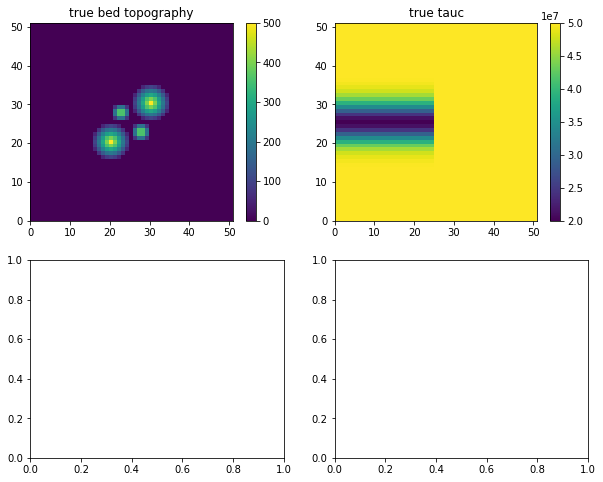

In [5]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
field = ax[0,0].pcolor(topg)
field1 = ax[0,1].pcolor(tauc)
#field2 = ax[1,0].pcolor(get_nc_data('icecap_output.nc', 'thk', 0))
#field3 = ax[1,1].pcolor(get_nc_data('icecap_output.nc', 'velsurf_mag', 0))

fig.colorbar(field, ax = ax[0,0])
fig.colorbar(field1, ax = ax[0,1])
#fig.colorbar(field2, ax = ax[1,0])
#fig.colorbar(field3, ax = ax[1,1])

ax[0,0].set_title('true bed topography')
ax[0,1].set_title('true tauc')
#ax[1,0].set_title('surface topography including icecap')
#ax[1,1].set_title('surface velocity')

In [6]:
##### define variables, set attributes, write data #####
# format: ['units', 'long_name', 'standard_name', '_FillValue', array]

vars = {'y':    ['m',
                 'y-coordinate in Cartesian system',
                 'projection_y_coordinate',
                 None,
                 y],
        'x':    ['m',
                 'x-coordinate in Cartesian system',
                 'projection_x_coordinate',
                 None,
                 x],
        'thk':  ['m',
                 'floating ice shelf thickness',
                 'land_ice_thickness',
                 None,
                 thk],
        'topg': ['m',
                 'bedrock surface elevation',
                 'bedrock_altitude',
                 None,
                 topg],
        'ice_surface_temp': ['K',
                             'annual mean air temperature at ice surface',
                             'surface_temperature',
                             None,
                             ice_surface_temp],
        'climatic_mass_balance': ['kg m-2 year-1',
                                  'mean annual net ice equivalent accumulation rate',
                                  'land_ice_surface_specific_mass_balance_flux',
                                  None,
                                  precip * ice_density],
        'land_ice_area_fraction_retreat' : ["1",
                                            "maximum ice extent mask",
                                            "",
                                            None,
                                            land_ice_area_fraction_retreat],
        'tauc': ['Pa',
                 'yield stress for basal till (plastic or pseudo-plastic model)',
                 'yield stress',
                 None,
                 tauc],
        }

##### define dimensions in NetCDF file #####
def create_nc_input(vars, WRIT_FILE):
    ncfile = NC(WRIT_FILE, 'w', format='NETCDF3_CLASSIC')
    xdim = ncfile.createDimension('x', nx)
    ydim = ncfile.createDimension('y', ny)
    
    for name in list(vars.keys()):
        [_, _, _, fill_value, data] = vars[name]
        if name in ['x', 'y']:
            var = ncfile.createVariable(name, 'f4', (name,))
        else:
            var = ncfile.createVariable(name, 'f4', ('y', 'x'), fill_value=fill_value)
        for each in zip(['units', 'long_name', 'standard_name'], vars[name]):
            if each[1]:
                setattr(var, each[0], each[1])
        var[:] = data
    
    # finish up
    ncfile.close()
    print("NetCDF file ", WRIT_FILE, " created")
    print('')
    
create_nc_input(vars, WRIT_FILE)

NetCDF file  icecap_initialSetup.nc  created



In [7]:
def gauss_filter(U, sigma, truncate):

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

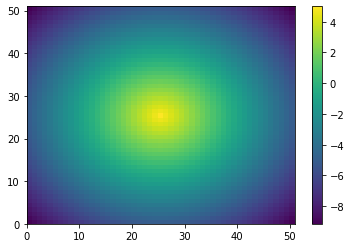

In [8]:
fig, axes = plt.subplots()
colors = plt.pcolor(precip, axes=axes)
fig.colorbar(colors)

In [9]:
def create_script(forward_or_iteration):
    print("""#!/bin/bash
    ###### run script for experiment icecap ######""")
    print('# build the PISM command')
    print('set -e #exit on error')
    print('')
    print('NN="$1"')
    print('CLIMATEFILE="$2"')
    print('DURATION=$3')
    print('OUTNAME=$4')
    print('OPT5=$5')
    print('RUNTIME="-ys 0 -ye $DURATION"')
    
    print('')
    print('CLIMATE="-surface given -surface_given_file $CLIMATEFILE"')
    print('grid="-Mx 51 -My 51 -Mz 30 -Mbz 1 -Lz 5000 -Lbz 1 -grid.recompute_longitude_and_latitude false"')
    print('PHYS="-stress_balance ssa+sia -ssa_flow_law isothermal_glen"')
    #print('PHYS="-stress_balance blatter"')
    print('THERMAL="-energy none"')
    print('CONF="-config_override icecap_conf.nc"')

    
    # power law sliding relation t_b=-C*|u|^(m-1)*u --> doesn't require thermal model
    print('SLIDING="-pseudo_plastic -pseudo_plastic_q 0.33333 -pseudo_plastic_uthreshold 3.1556926e7 -yield_stress constant"')
    
    print('echo')
    print('echo "# ======================================================================="')
    print('echo "# create icecap"')
    print('echo "#  $NN processors, $DURATION a run, 50 km grid, $CLIMATEFILE, $4"')
    print('echo "# ======================================================================="')
    
    print('')
    print('PISM_MPIDO="mpiexec -n "')
    
    print('')
    print('PISM_BIN=/home/thomas/pism/bin')
    print('PISM_EXEC="pismr"')
    print('EXVARS="temppabase,tempicethk_basal,velsurf_mag,mask,thk,usurf,velbase_mag, uvel, vvel"')
    
    print('')
    print('PISM="${PISM_BIN}/${PISM_EXEC}"')
    
    print('')
    print('EXSTEP=100')
    print('TSNAME=ts_$OUTNAME')
    print('TSTIMES=0:yearly:$DURATION')
    print('EXNAME=ex_$OUTNAME')
    print('EXTIMES=0:$EXSTEP:$DURATION')
    print('DIAGNOSTICS="-ts_file $TSNAME -ts_times $TSTIMES -extra_file $EXNAME -extra_times $EXTIMES -extra_vars $EXVARS"')
    
    print('DIAGNOSTICS_ITER="-save_file s_$OUTNAME -save_times $OPT5 -save_force_output_times"')

    
    print('')
    if forward_or_iteration == 'forward':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE -bootstrap ${grid} $SLIDING $THERMAL $CONF $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS -o $OUTNAME"')
    elif forward_or_iteration == 'iteration':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE $CONF $DIF $ENHANCE $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS_ITER -o $OUTNAME"')
    
    print('')
    print('echo')
    print('$cmd')

In [10]:
original_stdout = sys.stdout # Save a reference to the original standard output
with open('icecap_build_script.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    create_script('forward')
    sys.stdout = original_stdout # Reset the standard output to its original value
    f.close()

In [389]:
!chmod +x icecap_build_script.sh
!./icecap_build_script.sh 4 icecap_initialSetup.nc 10000 icecap_output.nc > icecap_output_log.txt

In [11]:
!tail icecap_output_log.txt

vy$Eh  diffusivity (overrides reporting (-extra_times)) (dt=2.85444)
S 9998-01-19 14.622h:    0.00369    0.01040          0.00533         62.62188
  SSA:     7 outer iterations, ~18.0 KSP iterations each
vy$Eh  diffusivity (overrides reporting (-extra_times)) (dt=2.85444)
S 10000-11-27 11.534h:    0.00369    0.01040          0.00533         62.62214
  SSA:     6 outer iterations, ~18.0 KSP iterations each
vy$Eh  reporting (-extra_times) (overrides end of the run) (dt=0.09457)
S 10001-01-01 00.000h:    0.00369    0.01040          0.00533         62.62201
... done with run
Writing model state to file `icecap_output.nc'...


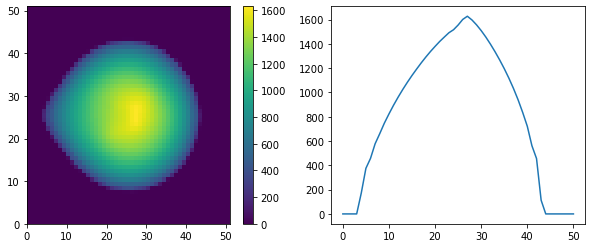

In [12]:
nc_data = get_nc_data('ex_icecap_output.nc', 'velbase_mag', -1)
nc_data2 = get_nc_data('ex_icecap_output.nc', 'usurf', -2)
fig, axes = plt.subplots(1,2, figsize=(10,4))
colors = axes[0].pcolor(nc_data2)
fig.colorbar(colors, ax=axes[0])
axes[1].plot(range(nx), nc_data2[25,:])

In [110]:
# bed recovery ###
S_ref = get_nc_data('icecap_output.nc', 'usurf', 0)
S_rec = copy.deepcopy(S_ref)

h_ref = get_nc_data('icecap_output.nc', 'thk', 0)
B_rec = np.zeros_like(topg)#np.minimum(S_ref - 1, np.ones_like(topg)*5000)
dh_ref = np.zeros_like(topg)#nc_data - nc_data2
B_init = copy.deepcopy(B_rec)

tauc_rec = np.ones_like(tauc)*5e7
tauc_init = copy.deepcopy(tauc_rec)
vel_ref = get_nc_data('icecap_output.nc', 'velsurf_mag', 0).data
vel_rec = copy.deepcopy(vel_ref)

mask = get_nc_data('icecap_output.nc', 'mask', 0)/2

B_rec_all = []
dh_all = []
B_misfit_vs_iter = []
dh_misfit_vs_iter = []
tauc_rec_all = []
vel_all = []
tauc_misfit_vs_iter=[]
vel_misfit_vs_iter=[]
misfit_thk_all = []
misfit_fr_all = []
S_rec_all = []

pmax = 5000
dt = 0.1
beta = 1
bw = 3
p_friction = 1000

!cp icecap_output.nc icecap_iteration_out.nc
    
original_stdout = sys.stdout
with open('icecap_iteration_script.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration')
    sys.stdout = original_stdout
    f.close()
!cp icecap_iteration_out.nc icecap_iteration_in.nc
!chmod +x icecap_iteration_script.sh

In [421]:
p_friction = 500
pmax = 2500

In [50]:
p = 99
B_rec = B_rec_all[p]
tauc_rec = inpaint_nans(tauc_rec_all[p])
S_rec = S_ref


In [111]:
for p in tqdm.trange(0, pmax):  
    
    h_old = S_rec - B_rec
    
    !cp icecap_iteration_out.nc icecap_iteration_in.nc
    #if p>0:
    #    mask = get_nc_data('icecap_iteration_in.nc', 'mask', 0)
    #    k = np.ones((bw+2, bw+2))
    #    buffer = ndimage.convolve(mask, k)/(bw+2)**2/2
    #    buffer[buffer>=.5] = 0
    #    buffer[buffer!=0] = (buffer[buffer!=0])*2
    #    B_rec -= (buffer) * np.mean(h_old) 
    #    h_old = S_ref - B_rec

    nc_updated = NC('icecap_iteration_in.nc', 'r+')
    nc_updated['tauc'][0,:,:]=tauc_rec
    nc_updated['thk'][0,:,:]=h_old
    nc_updated['topg'][0,:,:]=B_rec
    #nc_updated['climatic_mass_balance'][0,:,:]=np.maximum(nc_updated['climatic_mass_balance'][0:,:],0)
    nc_updated.close()
        
    cmd = ["./icecap_iteration_script.sh", '4', 'icecap_iteration_in.nc', str(dt), 'icecap_iteration_out.nc', str(dt/2)]
    subprocess.call(cmd, stdout=open('icecap_iteration_log.txt', 'a'))
    
    vel_rec = get_nc_data('icecap_iteration_out.nc', 'velsurf_mag', 0).data
    h_rec = get_nc_data('icecap_iteration_out.nc', 'thk', 0)
    dh_rec = (h_rec - h_old)/dt
    
    mask_iter = get_nc_data('icecap_iteration_out.nc', 'mask', 0)/2 #base buffer on ice mask produced by PISM --> faster than loop
    k = np.ones((bw, bw))
    buffer = ndimage.convolve(mask_iter, k)/(bw)**2 #smooth ice mask...
    criterion = np.logical_and(np.logical_and(buffer > 0, buffer != 1), mask==1)

    u = get_nc_data('icecap_iteration_out.nc', 'uvelsurf', 0).data
    #u[criterion] = 0
    v = get_nc_data('icecap_iteration_out.nc', 'vvelsurf', 0).data
    #v[criterion] = 0
    
    #misfit_fr = shift((vel_ref-vel_rec), u, v, .3)
    misfit = dh_rec - dh_ref    
    misfit[np.logical_and(abs(u)>0, abs(v)>0)] = shift((dh_rec-dh_ref), u, v, 0.3)[np.logical_and(abs(u)>0, abs(v)>0)]
    
    #misfit_lowpass = ndimage.gaussian_filter(misfit, 1)
    #misfit_highpass = misfit - misfit_lowpass
    
    #tauc_rec = tauc_rec - beta * (misfit_fr)*1e6
    B_rec = B_rec - beta * (misfit)
    #S_rec[np.logical_and(mask==1, h_rec>20)] += (beta*.05) * misfit_highpass[np.logical_and(mask==1, h_rec>20)] 
    S_rec[np.logical_and(mask==1, h_rec>20)] += (beta*0.01) * misfit[np.logical_and(mask==1, h_rec>20)] 

    '''

    H_rec = S_ref - B_rec
    B_rec = ndimage.gaussian_filter(H_rec, 1, truncate=1)
    B_rec = S_ref - H_rec
    '''
    ### buffer ###
    #B_rec[criterion]=0
    #h_inpaint = S_rec - B_rec
    B_rec[criterion] = np.nan #...and take those values in the transition between ice and no ice;
    B_rec = inpaint_nans(B_rec)
    #B_rec = S_rec - h_inpaint
    #tauc_rec[criterion]=1e8
    ### buffer end ###

    B_rec[mask==0] = S_ref[mask==0]
    S_rec[mask==0] = S_ref[mask==0]
    B_rec[B_rec>S_rec] = S_rec[B_rec>S_rec]
    B_rec_all.append(B_rec)
    dh_all.append(dh_rec)
    tauc_rec[mask==0] = tauc[mask==0]
    tauc_rec_all.append(tauc_rec.copy())
    vel_all.append(vel_rec)
    S_rec_all.append(S_rec.copy())
    
    tauc_misfit_vs_iter.append(np.mean(abs(tauc_rec[mask==1]-tauc[mask==1])))
    vel_misfit_vs_iter.append(np.mean(abs(vel_rec[mask==1]-vel_ref[mask==1])))
    B_misfit_vs_iter.append(np.mean(abs(B_rec[mask==1]-topg[mask==1])))
    dh_misfit_vs_iter.append(np.mean(abs(dh_rec[mask==1]-dh_ref[mask==1])))
    misfit[mask==0] = np.nan
    #misfit_fr_all.append(misfit_fr)
    #misfit_thk_all.append(misfit_thk)
    
    if p>0 and p%p_friction == 0:   

        vel_mismatch = np.maximum(np.minimum((vel_rec - vel_ref)/vel_ref, 0.5), -0.5)
        vel_mismatch[mask==0]=np.nan
        vel_mismatch =  gauss_filter(vel_mismatch, .6,2)
        vel_mismatch[np.isnan(vel_mismatch)]=0
        tauc_rec += vel_mismatch * tauc_rec  
        tauc_rec[np.logical_and(mask==1, criterion)] = np.nan
        tauc_rec = inpaint_nans(tauc_rec)

 20%|███████████████████████████████████████▏                                                                                                                                                            | 1000/5000 [13:41<55:36,  1.20it/s]/tmp/ipykernel_11938/1453839662.py:11: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:13:21<00:00,  1.14it/s]


Text(0.5, 1.0, 'tauc misfit after 5000 iterations')

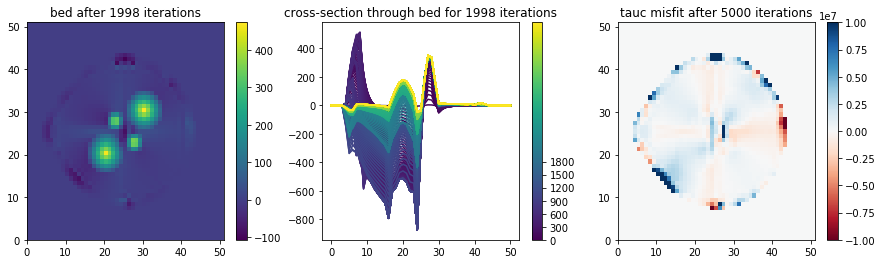

In [143]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0,1,len(B_rec_all))]
bounds=np.linspace(0,len(B_rec_all), 1000)
fig, axes = plt.subplots(1,3, figsize=(15,4))
field = axes[0].pcolor(B_rec)#, vmin = -2, vmax = 2, cmap='RdBu')
fig.colorbar(field, ax=axes[0])
for i in range(0,len(B_rec_all),10):
    lines = axes[1].plot(range(nx), B_rec_all[i][23,:], color=colors[i])

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax = axes[1], ticks=range(0,2000, 300))
field2 = axes[2].pcolor(tauc_rec_all[-1]-tauc, vmin = -1e7, vmax = 1e7, cmap='RdBu')
fig.colorbar(field2, ax = axes[2])

axes[0].set_title('bed after 1998 iterations')
axes[1].set_title('cross-section through bed for 1998 iterations')
axes[2].set_title('tauc misfit after 5000 iterations')

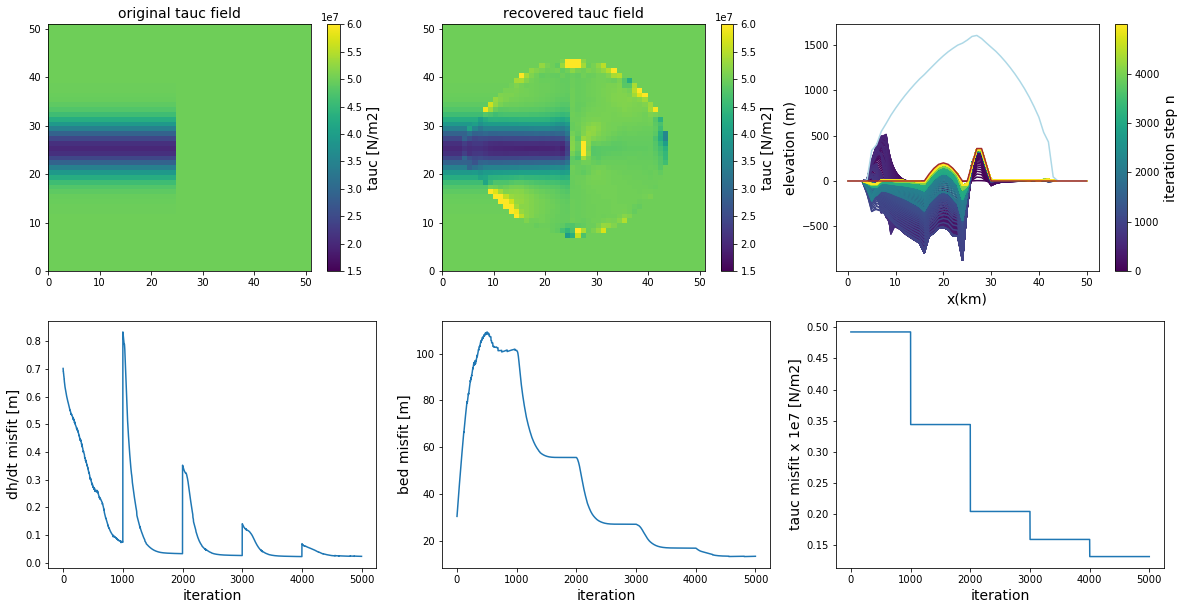

In [183]:
fs = 14

fig, ax = plt.subplots(2,3, figsize=(20,10))

field = ax[0,0].pcolor(tauc, vmin = 1.5e7, vmax = 6e7)
cbar = fig.colorbar(field, ax=ax[0,0])

field1 = ax[0,1].pcolor(tauc_rec, vmin = 1.5e7, vmax = 6e7)
cbar1 = fig.colorbar(field1, ax=ax[0,1])

#field2 = ax[0,2].pcolor((vel_all[999].data-vel_ref)/vel_ref, vmin = -.5, vmax = .5, cmap='RdBu')
#cbar2 = fig.colorbar(field2, ax=ax[0,2])

#field3 = ax[0,3].pcolor((vel_all[4999].data-vel_ref)/vel_ref, vmin = -.5, vmax = .5, cmap='RdBu')
#cbar3 = fig.colorbar(field3, ax=ax[0,3])

for i in range(0,len(B_rec_all),10):
    lines = ax[0,2].plot(range(nx), B_rec_all[i][23,:], color=colors[i])
    #lines = ax[0].plot(range(nx), S_rec_all[i][:,25], color=colors[i])
lines2 = ax[0,2].plot(range(nx), S_ref[23,:], color = 'lightblue')
lines1 = ax[0,2].plot(range(nx), topg[23,:], color='brown')
cbar4 = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax = ax[0,2], ticks=range(0,5000,1000))
cbar4.set_label('iteration step n', fontsize= fs)
ax[0,2].set_xlabel('x(km)', fontsize= fs)
ax[0,2].set_ylabel('elevation (m)', fontsize= fs)

ax[1,0].plot(dh_misfit_vs_iter)
ax[1,1].plot(B_misfit_vs_iter)
ax[1,2].plot(np.array(tauc_misfit_vs_iter)/1e7)

cbar.set_label('tauc [N/m2]', fontsize= fs)
cbar1.set_label('tauc [N/m2]', fontsize= fs)
cbar2.set_label('velotiy misfit after 1000 iterations', fontsize= fs)
cbar3.set_label('velotiy misfit after 5000 iterations', fontsize= fs)

ax[0,0].set_title('original tauc field', fontsize= fs)
ax[0,1].set_title('recovered tauc field', fontsize= fs)

ax[1,0].set_ylabel('dh/dt misfit [m]', fontsize= fs)
ax[1,1].set_ylabel('bed misfit [m]', fontsize= fs)
ax[1,2].set_ylabel('tauc misfit x 1e7 [N/m2]', fontsize= fs)
ax[1,0].set_xlabel('iteration', fontsize= fs)
ax[1,1].set_xlabel('iteration', fontsize= fs)
ax[1,2].set_xlabel('iteration', fontsize= fs)

plt.savefig('./figures/icecap/sliding_icecap_1.0.png', dpi = 300)

Text(0.5, 1.0, 'cross-section through original tauc (brown),\n initial tauc guess (blue) and recovered tauc')

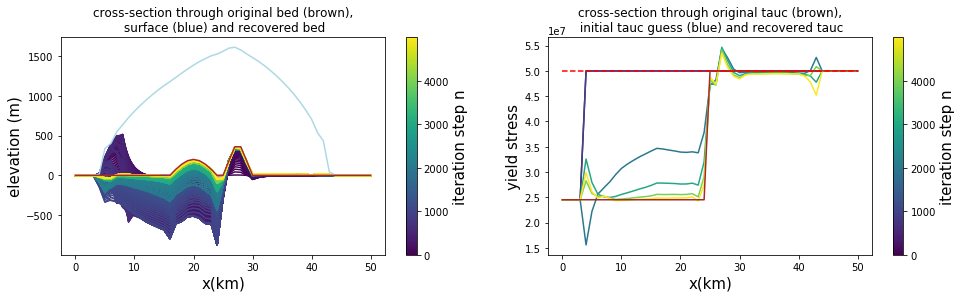

In [141]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all))]
bounds=np.linspace(0,len(B_rec_all), 1000)
norm = plt_colors.BoundaryNorm(bounds, colormap.N)

fig, ax = plt.subplots(1,2, figsize=(16,4))
for i in range(0,len(B_rec_all),10):
    lines = ax[0].plot(range(nx), B_rec_all[i][23,:], color=colors[i])
    #lines = ax[0].plot(range(nx), S_rec_all[i][:,25], color=colors[i])
lines2 = ax[0].plot(range(nx), S_ref[23,:], color = 'lightblue')
lines1 = ax[0].plot(range(nx), topg[23,:], color='brown')
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax = ax[0], ticks=range(0,5000,1000))
cbar.set_label('iteration step n', fontsize= 15)
ax[0].set_xlabel('x(km)', fontsize= 15)
ax[0].set_ylabel('elevation (m)', fontsize= 15)
#plt.savefig('./figures/icecap_crosssection.png', dpi = 400)

for i in range(0,len(tauc_rec_all),999):
    lines = ax[1].plot(range(nx), tauc_rec_all[i][23,:], color=colors[i])
lines2 = ax[1].plot(range(nx), tauc[23,:], color = 'brown')
lines1 = ax[1].plot(range(nx), tauc_init[23,:], '--',color='red')
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax = ax[1], ticks=range(0,5000,1000))
cbar.set_label('iteration step n', fontsize= 15)
ax[1].set_xlabel('x(km)', fontsize= 15)
ax[1].set_ylabel('yield stress', fontsize= 15)

ax[0].set_title('cross-section through original bed (brown),\n surface (blue) and recovered bed')
ax[1].set_title('cross-section through original tauc (brown),\n initial tauc guess (blue) and recovered tauc')

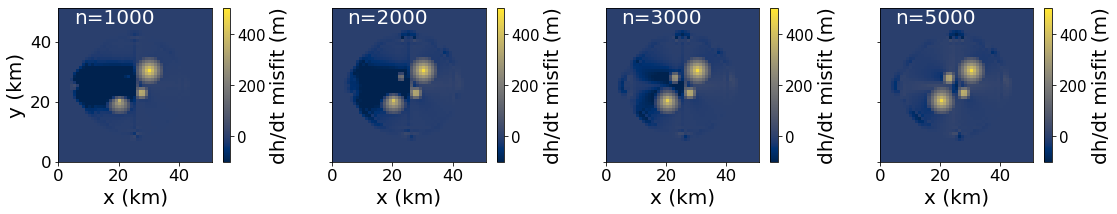

In [119]:
fs = 20
ls = 15
plot_iterations = [999, 1999, 2999, 4999]

fig, ax = plt.subplots(1,4, figsize=(16,3), sharey=True)
for q,i in enumerate(plot_iterations):
    #field3 = ax[q].pcolor(dh_all[i], vmin=-5, vmax=5, cmap='RdBu')
    field3 = ax[q].pcolor(B_rec_all[i], vmin=-100, vmax=500, cmap='cividis')
    ax[q].set_aspect('equal', 'box')
    ax[q].text(.1, .9, 'n={}'.format(i+1), transform = ax[q].transAxes, fontsize=fs, color='w')
    cbar3 = fig.colorbar(field3, ax = ax[q])
    cbar3.set_label('dh/dt misfit (m)', fontsize=fs)
    cbar3.ax.tick_params(axis='both', which='major', labelsize=ls)

    ax[q].set_xlabel('x (km)', fontsize=fs)
    ax[q].tick_params(axis='both', which='major', labelsize=fs/1.2)

    if i == plot_iterations[0]:
        ax[0].set_ylabel('y (km)', fontsize=fs)

plt.tight_layout()
#plt.savefig('./figures/icecap/misfit_panel.png', dpi = 800)

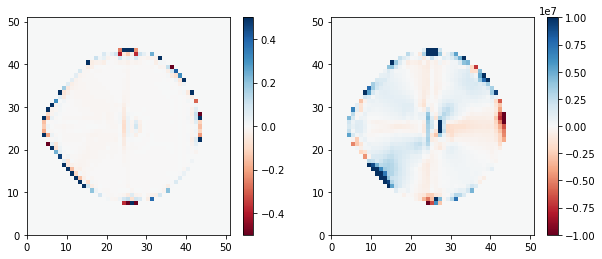

In [121]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
field = ax[0].pcolor((vel_rec - vel_ref)/vel_ref, vmin = -.5, vmax = .5, cmap='RdBu')
field1 = ax[1].pcolor((tauc_rec) - tauc, vmin = -1e7, vmax = 1e7, cmap='RdBu')
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

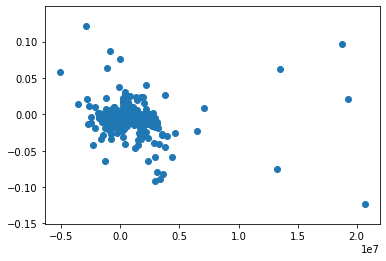

In [122]:
plt.scatter((tauc_rec_all[-1] - tauc)[np.logical_and(mask==1, criterion==0)], ((vel_all[-1] - vel_ref)/vel_ref)[np.logical_and(mask==1, criterion==0)])

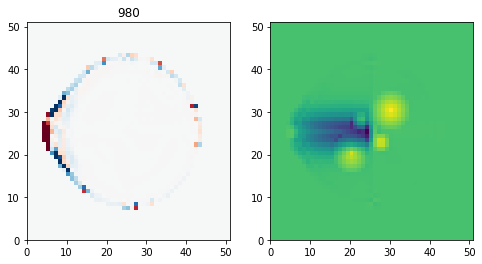

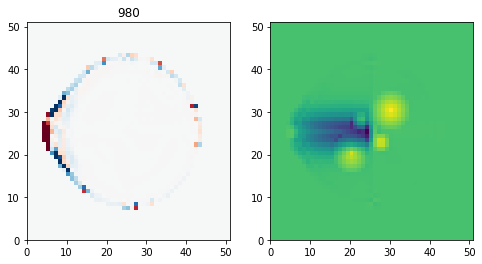

In [404]:
from IPython.display import display, clear_output
fig, axes = plt.subplots(1,2,figsize=(8,4))
for i in range(0,len(tauc_rec_all),20):
    field = axes[0].pcolor(dh_all[i], cmap='RdBu', vmin=-1, vmax=1)
    field = axes[1].pcolor(B_rec_all[i])
    axes[0].set_title(i)
    clear_output(wait=True)
    display(fig)

In [75]:
import random
rand_x = []
rand_y = []
rand_tauc = []
radar_mask = np.zeros_like(topg)
radar_bed = np.zeros_like(topg)
for i in range(1000):
    rand_x.append(random.choice(range(np.shape(topg)[0])))
    rand_y.append(random.choice(range(np.shape(topg)[1])))
    rand_tauc.append(tauc[rand_x[i], rand_y[i]])
    radar_mask[rand_x[i], rand_y[i]]=1
    radar_bed[rand_x[i], rand_y[i]]=topg[rand_x[i], rand_y[i]]

In [133]:
rad_msk = radar_mask[3:-3,3:-3]
rad_msk_nan = copy.deepcopy(rad_msk)
rad_msk_nan[rad_msk==0] = np.nan

#H = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'thk', 0)[1:-1,1:-1]
h = copy.deepcopy(S_ref)
H = np.zeros_like(h)
H[radar_mask==1] = h[radar_mask==1] - radar_bed[radar_mask==1]

x_d = np.transpose(np.where(radar_mask==1))
grid_x, grid_y = np.meshgrid(range(np.shape(radar_mask)[1]), range(np.shape(radar_mask)[0]))
rad_bed_int = griddata(x_d, (radar_bed)[radar_mask==1], (grid_y, grid_x), method='nearest')
H_int = h - rad_bed_int
#H_int = gauss_filter(H_int, 1, 3)

res = 2*Lx/nx

dhdx = (h[1:-1,1:-1] - h[1:-1,0:-2])/res
dhdy = (h[1:-1,1:-1] - h[0:-2,1:-1])/res

A = 3.1689e-24

alpha = (np.sqrt(dhdx**2+dhdy**2))
SIA_u = (9.8*ice_density)**3*(dhdx)**3*-0.5*A*H_int[1:-1,1:-1]**4
SIA_v = (9.8*ice_density)**3*(dhdy)**3*-0.5*A*H_int[1:-1,1:-1]**4
SIA_vel = np.sqrt(SIA_u**2+SIA_v**2)

u = get_nc_data('./icecap_output.nc', 'uvelsurf', 0)
v = get_nc_data('./icecap_output.nc', 'vvelsurf', 0)

SSA_u = u[1:-1, 1:-1]/secpera - SIA_u
SSA_v = v[1:-1, 1:-1]/secpera - SIA_v
SSA_vel = np.sqrt(SSA_u**2+SSA_v**2)

SSA_u_mod = get_nc_data('./icecap_output.nc', 'u_ssa', 0)[1:-1,1:-1]
SSA_v_mod = get_nc_data('./icecap_output.nc', 'v_ssa', 0)[1:-1,1:-1]
SSA_vel_mod = np.sqrt(SSA_u_mod**2 + SSA_v_mod**2)

dudx = -(SSA_u[1:-1,1:-1] - SSA_u[1:-1,0:-2])/res
dudy = -(SSA_u[1:-1,1:-1] - SSA_u[0:-2,1:-1])/res
dvdx = -(SSA_v[1:-1,1:-1] - SSA_v[1:-1, 0:-2])/res
dvdy = -(SSA_v[1:-1,1:-1] - SSA_v[0:-2,1:-1])/res

exx = -(u[1:-1,1:-1] - u[1:-1,0:-2])/res
exy = -(u[1:-1,1:-1] - u[0:-2,1:-1])/res
eyx = -(v[1:-1,1:-1] - v[1:-1,0:-2])/res
eyy = -(v[1:-1,1:-1] - v[0:-2,1:-1])/res

#e_xy = 0.5*(dudy+dvdx)
B = A**(-1/3)
v_eff = 0.5*B*(exx**2+eyy**2+exx*eyy+0.25*(eyx+exy)**2)**(1/3)

s1 = 2*v_eff[1:-1,1:-1]*H_int[2:-2,2:-2]*(2*dudx+dvdy)
s2 = v_eff[1:-1,1:-1]*H_int[2:-2,2:-2]*(dudy+dvdx)

s3 = v_eff[1:-1,1:-1]*H_int[2:-2,2:-2]*(dudy+dvdx)
s4 = 2*v_eff[1:-1,1:-1]*H_int[2:-2,2:-2]*(dudx+2*dvdy)

t1 = -(s1[1:-1,1:-1] - s1[1:-1,0:-2])/res
t2 = -(s2[1:-1,1:-1] - s2[0:-2,1:-1])/res

t3 = -(s3[1:-1,1:-1] - s3[1:-1,0:-2])/res
t4 = -(s4[1:-1,1:-1] - s2[0:-2,1:-1])/res

taud_x = ice_density*9.8*H_int[3:-3,3:-3]*np.sin(np.arctan(dhdx[2:-2,2:-2]))
taud_y = ice_density*9.8*H_int[3:-3,3:-3]*np.sin(np.arctan(dhdy[2:-2,2:-2]))

tau_d = get_nc_data('./icecap_output.nc', 'taud_mag', 0)[3:-3,3:-3]
tau_b = get_nc_data('./icecap_output.nc', 'taub_mag', 0)[3:-3,3:-3]

taub_x = taud_x-t1-t2
taub_y = taud_y - t3 - t4
taub_cal = np.sqrt(taub_x**2+taub_y**2)

tauc_cal = -taub_cal/(SSA_vel[2:-2,2:-2]*secpera)*3.1556926e7**.2*abs(SSA_vel[2:-2,2:-2]*secpera)**(1-0.2)

tauc_x = -taub_x/(SSA_u[2:-2,2:-2]*secpera)*3.1556926e7**.2*abs(SSA_vel[2:-2,2:-2]*secpera)**(1-0.2)
tauc_y = -taub_y/(SSA_v[2:-2,2:-2]*secpera)*3.1556926e7**.2*abs(SSA_vel[2:-2,2:-2]*secpera)**(1-0.2)
tauc_xy = np.sqrt(tauc_x**2+tauc_y**2)
#tauc_xy_s = gauss_filter(tauc_xy, 1, 3)

x_d_rad_msk = np.transpose(np.where(rad_msk==1))
tauc_rec = griddata(x_d_rad_msk, tauc_xy[rad_msk==1], (grid_y, grid_x), method='nearest')
#tauc = gauss_filter(tauc, 1, 3)

<ipython-input-133-9a57ea9411ce>:33: RuntimeWarning: invalid value encountered in sqrt
  SSA_vel = np.sqrt(SSA_u**2+SSA_v**2)
<ipython-input-133-9a57ea9411ce>:73: RuntimeWarning: invalid value encountered in sqrt
  taub_cal = np.sqrt(taub_x**2+taub_y**2)
<ipython-input-133-9a57ea9411ce>:79: RuntimeWarning: invalid value encountered in sqrt
  tauc_xy = np.sqrt(tauc_x**2+tauc_y**2)


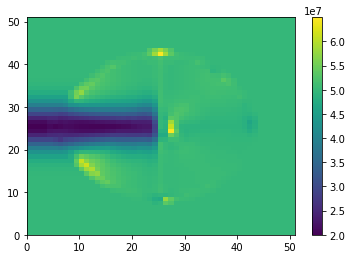

In [34]:
fig, ax = plt.subplots()
field = ax.pcolor(inpaint_nans(tauc_rec_all[2001]))
fig.colorbar(field, ax = ax)

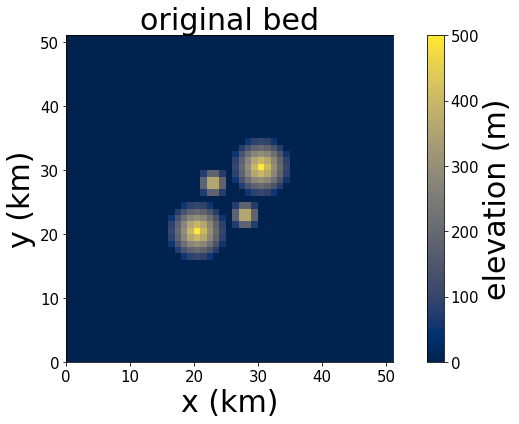

In [242]:
fig, ax = plt.subplots(figsize=(10,6))
field = plt.pcolor(topg, vmin = 0, vmax= 500, cmap='cividis')
cbar = fig.colorbar(field, ax = ax)
ax.set_aspect('equal', 'box')
ax.set_xlabel('x (km)', fontsize=30)
ax.set_ylabel('y (km)', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('original bed', fontsize=30)
#ax.set_title('original bed', fontsize=30)
cbar.set_label('elevation (m)', fontsize=30)
cbar.ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_facecolor((1.0, 1, 1))
plt.tight_layout()

plt.savefig('./figures/icecap/topg_cividis.png', dpi=800)

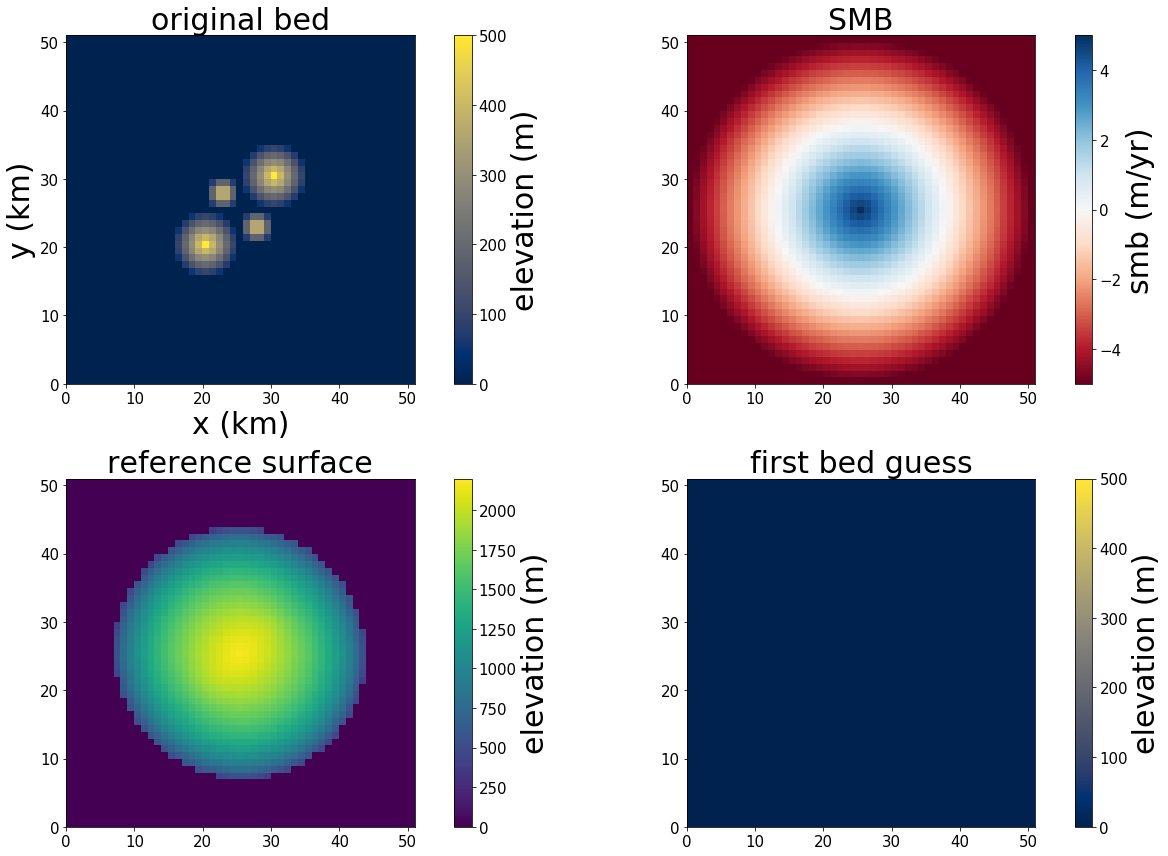

In [307]:
fs = 30
ls = 15

fig, ax = plt.subplots(2,2, figsize=(20,12))

field = ax[1,0].pcolor(S_rec, vmin = 0, vmax= 2200)
cbar = fig.colorbar(field, ax = ax[1,0])
ax[1,0].set_aspect('equal', 'box')
#ax[1,0].set_xlabel('x (km)', fontsize=fs)
ax[1,0].tick_params(axis='both', which='major', labelsize=ls)
#ax[1,0].set_ylabel('y (km)', fontsize=fs)
ax[1,0].set_title('reference surface', fontsize=fs)
#ax.set_title('original bed', fontsize=fs)
cbar.set_label('elevation (m)', fontsize=fs)
cbar.ax.tick_params(axis='both', which='major', labelsize=ls)
ax[1,0].set_facecolor((1.0, 1, 1))
plt.tight_layout()

field = ax[0,0].pcolor(topg, vmin = 0, vmax= 500, cmap = "cividis")
cbar = fig.colorbar(field, ax = ax[0,0])
ax[0,0].set_aspect('equal', 'box')
ax[0,0].set_xlabel('x (km)', fontsize=fs)
ax[0,0].tick_params(axis='both', which='major', labelsize=ls)
ax[0,0].set_ylabel('y (km)', fontsize=fs)
ax[0,0].set_title('original bed', fontsize=fs)
#ax.set_title('original bed', fontsize=fs)
cbar.set_label('elevation (m)', fontsize=fs)
cbar.ax.tick_params(axis='both', which='major', labelsize=ls)
ax[0,0].set_facecolor((1.0, 1, 1))
plt.tight_layout()

field = ax[0,1].pcolor(precip, vmin = -5, vmax= 5, cmap = "RdBu")
cbar = fig.colorbar(field, ax = ax[0,1])
ax[0,1].set_aspect('equal', 'box')
#ax[0,1].set_xlabel('x (km)', fontsize=fs)
ax[0,1].tick_params(axis='both', which='major', labelsize=ls)
#ax[0,1].set_ylabel('y (km)', fontsize=fs)
ax[0,1].set_title('SMB', fontsize=fs)
#ax.set_title('original bed', fontsize=fs)
cbar.set_label('smb (m/yr)', fontsize=fs)
cbar.ax.tick_params(axis='both', which='major', labelsize=ls)
ax[0,1].set_facecolor((1.0, 1, 1))
plt.tight_layout()

field = ax[1,1].pcolor(np.zeros_like(topg), vmin = 0, vmax= 500, cmap = "cividis")
cbar = fig.colorbar(field, ax = ax[1,1])
ax[1,1].set_aspect('equal', 'box')
#ax[1,1].set_xlabel('x (km)', fontsize=fs)
ax[1,1].tick_params(axis='both', which='major', labelsize=ls)
#ax[1,1].set_ylabel('y (km)', fontsize=fs)
ax[1,1].set_title('first bed guess', fontsize=fs)
#ax.set_title('original bed', fontsize=fs)
cbar.set_label('elevation (m)', fontsize=fs)
cbar.ax.tick_params(axis='both', which='major', labelsize=ls)
ax[1,1].set_facecolor((1.0, 1, 1))
plt.tight_layout()

plt.savefig('./figures/icecap/inputs.png', dpi=800, transparent = True)

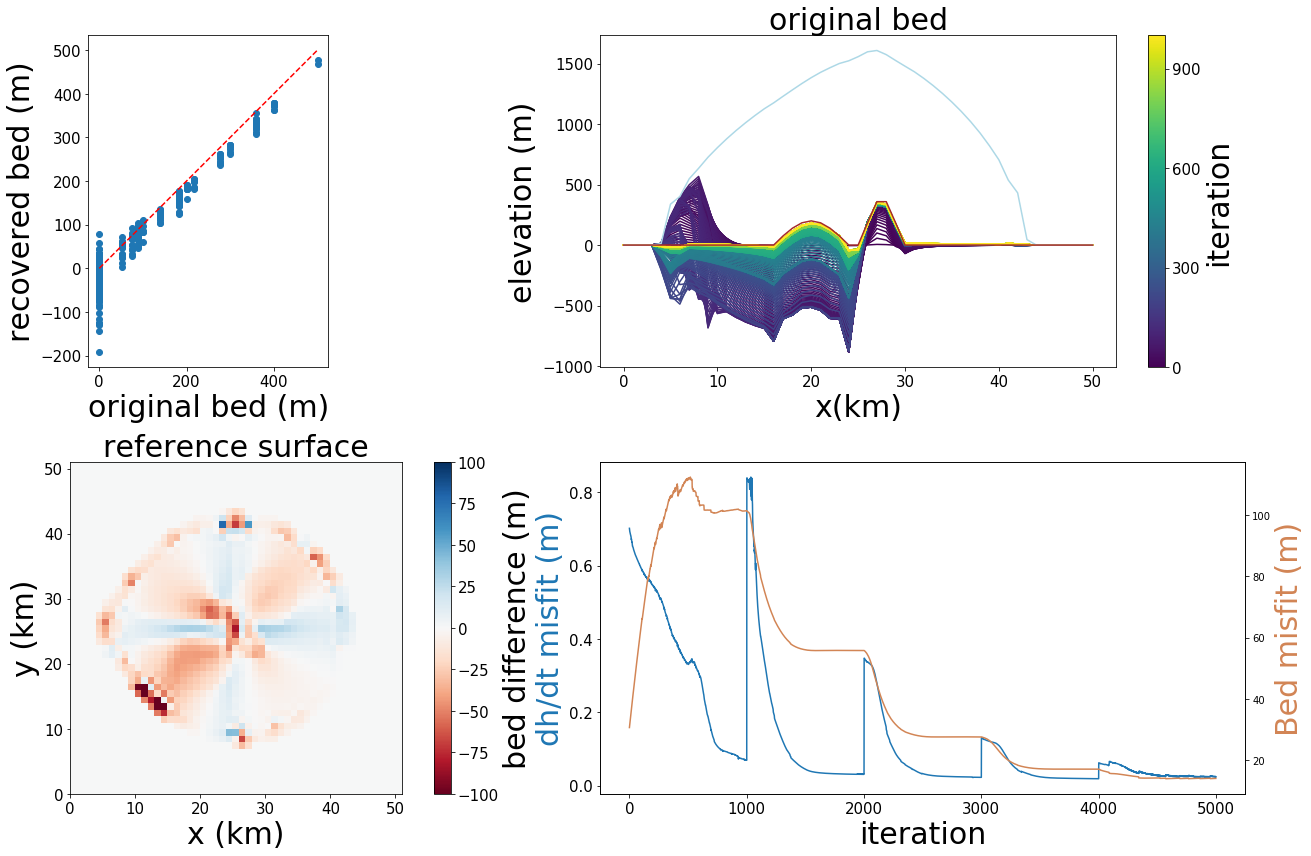

In [433]:
fs = 30
ls = 15

fig, ax = plt.subplots(2,2, figsize=(20,12))

field = ax[1,0].pcolor(B_rec - topg, vmin = -100, vmax= 100, cmap='RdBu')
cbar = fig.colorbar(field, ax = ax[1,0])
ax[1,0].set_aspect('equal', 'box')
ax[1,0].set_xlabel('x (km)', fontsize=fs)
ax[1,0].tick_params(axis='both', which='major', labelsize=ls)
ax[1,0].set_ylabel('y (km)', fontsize=fs)
ax[1,0].set_title('reference surface', fontsize=fs)
#ax.set_title('original bed', fontsize=fs)
cbar.set_label('bed difference (m)', fontsize=fs)
cbar.ax.tick_params(axis='both', which='major', labelsize=ls)
ax[1,0].set_facecolor((1.0, 1, 1))
plt.tight_layout()

for i in range(0,len(B_rec_all),10):
    lines = ax[0,1].plot(range(nx), B_rec_all[i][23,:], color=colors[i])
    #lines = ax[0].plot(range(nx), S_rec_all[i][:,25], color=colors[i])
lines2 = ax[0,1].plot(range(nx), S_ref[23,:], color = 'lightblue')
lines1 = ax[0,1].plot(range(nx), topg[23,:], color='brown')
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax = ax[0,1], ticks=range(0,2000,300))
cbar.set_label('iteration step n', fontsize= fs)
ax[0,1].set_xlabel('x(km)', fontsize= fs)
ax[0,1].tick_params(axis='both', which='major', labelsize=ls)
ax[0,1].set_ylabel('elevation (m)', fontsize= fs)
ax[0,1].set_title('original bed', fontsize=fs)
cbar.set_label('iteration', fontsize=fs)
cbar.ax.tick_params(axis='both', which='major', labelsize=ls)
#ax[0,1].set_facecolor((1.0, 1, 1))
plt.tight_layout()

field = ax[0,0].scatter((topg)[mask==1], (S_ref-S_rec+B_rec)[mask==1])
line = ax[0,0].plot(range(500), range(500), '--', c='r')
ax[0,0].set_aspect('equal', 'box')
ax[0,0].set_xlabel('original bed (m)', fontsize=fs)
ax[0,0].tick_params(axis='both', which='major', labelsize=ls)
ax[0,0].set_ylabel('recovered bed (m)', fontsize=fs)
#ax[0,0].set_title('SMB', fontsize=fs)

ax[0,0].set_facecolor((1.0, 1, 1))
plt.tight_layout()

field = ax[1,1].plot(dh_misfit_vs_iter)
ax[1,1].set_xlabel('iteration', fontsize=fs)
ax[1,1].tick_params(axis='both', which='major', labelsize=ls)
ax[1,1].set_ylabel('dh/dt misfit (m)', fontsize=fs, color = 'C0')
#ax[0,0].set_title('SMB', fontsize=fs)
ax1 = ax[1,1].twinx()
ax1.plot(B_misfit_vs_iter, c = plt.cm.copper(np.linspace(0,1,4)[2]))
ax1.set_ylabel('Bed misfit (m)', fontsize = fs, color = plt.cm.copper(np.linspace(0,1,4)[2]))
ax[1,1].set_facecolor((1.0, 1, 1))
plt.tight_layout()


#plt.savefig('./figures/icecap/outcome.png', dpi=800)

In [ ]:
save_and_commit('./icecap.ipynb', 'icecap', 'icecap_iteration_out.nc', 'no great output, just to save friction inversion from radar')